# SVM - Climate Sentiment Multiclass Classification
## CS522 Project

### Dataset: 
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

### Imports

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from cleanlab.classification import LearningWithNoisyLabels
from sklearn.ensemble import IsolationForest
from Common.DataCenter import data_center
from Common.preprocessor import normalize_preprocessing
from Common.UtilFuncs import print_evaluation, Evaluator, Lab

%matplotlib inline

Ev  = Evaluator()


### Text preprocessing

In [2]:
# parameter: original X of training set and test set
# return:  vectorised X of training set and test set
def text_preprocessing(X_train, X_test):
    # preprocessing with traditional NLP methodology
    X_train_normalized = normalize_preprocessing(X_train)
    X_test_normalized  = normalize_preprocessing(X_test)
    
    # vectorization
    # Convert texts to vectors by TFIDF
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X_train_vec  = vectorizer.fit_transform(X_train_normalized)
    X_test_vec   = vectorizer.transform(X_test_normalized)
      
    return X_train_vec, X_test_vec

### One-hot encoding, convert the labels to vectors (4 x 1) each

In [3]:
# parameter: original y of training set, original y of test set
# return:  encoded y of training set and test set
def one_hot_encoding(y_train, y_test):
    mlb          = MultiLabelBinarizer()
    y_train_vec  = mlb.fit_transform(map(str, y_train))
    y_test_vec   = mlb.transform(map(str, y_test))
    return y_train_vec, y_test_vec


### Run SVM

In [4]:
# parameter:  vectorised X and encoded y of training set and test set
def run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec):
    # Run SVM - fit and predict
    SVM             = OneVsRestClassifier(LinearSVC(dual=False, class_weight='balanced'), n_jobs=-1)
    SVM.fit(X_train_vec, y_train_vec)
    y_pred          = SVM.predict(X_test_vec)
    return  y_pred


### Do an experiment

In [5]:
# do an experiment without denoising
# Parameter: original X,y of training set and test set
# Return evaluation info
def do_experiment(train_df, test_df):
    X_train, y_train = data_center.Xy(train_df)
    X_test, y_test   = data_center.Xy(test_df)
    
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # Run SVM and evaluate the results
    y_pred = run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec)

    # Print the evaluation
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])
    evaluateDF = Ev.evaluate(y_test_vec, y_pred)
    return evaluateDF

# do an experiment denoised by ConfidentLearning
# Parameter: training set and test set
# Return evaluation info, denoising info
def do_experiment_denoised_by_ConfidentLearning(train_df, test_df):
    X_train, y_train = data_center.Xy(train_df)
    X_test, y_test   = data_center.Xy(test_df)
    
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # LearningWithNoisyLabels require the classifier has the entry predict_proba()
    # So, use CalibratedClassifierCV to wrap LinearSVC
    SVM = CalibratedClassifierCV(LinearSVC(dual=False, class_weight='balanced'))
    rp = LearningWithNoisyLabels(clf=SVM, seed=522)
    rp.fit(X_train_vec, np.array(y_train))
    y_pred = rp.predict(X_test_vec)

    # Print the evaluation
    # One hot encoding for print_evaluation()
    _, y_pred = one_hot_encoding(y_train, y_pred)
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])

    evaluateDF = Ev.evaluate(y_test_vec, y_pred)
    return evaluateDF, None

# do an experiment denoised by IsolationForest
# Parameter: training set and test set
# Return evaluation info, denoising info
def do_experiment_denoised_by_IsolationForest(train_df, test_df):
    X_train, y_train = data_center.Xy(train_df)
    X_test, y_test   = data_center.Xy(test_df)

    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    X = X_train_vec

    # IsolationForest
    # n_estimators is the number of trees, try bigger values
    iforest = IsolationForest(n_estimators=20000, max_samples='auto',
                              contamination=0.1, max_features=3,
                              bootstrap=False, n_jobs=-1, random_state=1)

    df = train_df.copy()
    df['label'] = iforest.fit_predict(X)

    # give the anomaly score
    df['scores'] = iforest.decision_function(X)
    df.sort_values(by="scores", inplace=True, ascending=True)

    denoisedDF = df[df.label!=-1]
    X_train, y_train = data_center.Xy(denoisedDF)

    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # Run SVM and evaluate the results
    y_pred = run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec)

    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])
    evaluateDF = Ev.evaluate(y_test_vec, y_pred)

    return evaluateDF, denoisedDF


### Main entry
**The settings of the noise sources.**

In [6]:
# Each item: source -> (size, distribution)
noisy_set_sizes = {
    'mislabeled' : (8600, None),                   # max size: 15000
    'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, "reserve_labels"),       # max size: 5000
}


**Choose a experiment without denoising**

In [7]:
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
experiment_without_denoising = {
    'SVM' : (do_experiment, 1),
}


**Choose a experiment with denoising**

In [8]:
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
experiment_with_denoising = {
    'Confident Learning' : (do_experiment_denoised_by_ConfidentLearning, 1),
    'Isolation Forest'   : (do_experiment_denoised_by_IsolationForest,   0),
}


**The training set of each experiment**

In [9]:
origin_train_set_sizes = [2000, 4000, 5000, 8000, 10000, 15000, 20000]
noisy_train_set_sizes  = [(4000, 1000), (8000, 2000), (15000, 5000)]


**Initialize the lab, which will run a serial of experiments**

In [10]:
lab = Lab("twitter_sentiment_data_clean.csv", noisy_sources = noisy_set_sizes, total_train_size = 20000, total_test_size = 4000)


**The database and split it into training set, test set, noisy set, validation set.<br>
Review the summary of the whole data**

In [11]:
lab.dc.print_summary()


###################################### Data Summary #############################################
  Original set size: 40908
      sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
  Training set size: 20000
  Test set size: 4000
  Noisy set size: 25800
  Validation set size: 1000
      noise sources ('mislabeled', 'irrelevant', 'translated'): 33.3%, 33.3%, 33.3%
##################################################################################################


**To see the data features via a demo**

In [12]:
train_df = lab.dc.get_train_with_noisy_df(15000,5000)
data_center.print_data(train_df.head(15))


,noise,noise_text,sentiment,origin(sentiment),tweetid...,message...
0,1,mislabeled,3,2,8108306943,Regional/Global seabird stress
1,0,none,2,-,9536174384,I have to write an essay over
2,1,mislabeled,1,3,8645926535,Barack Obama warns climate cha
3,0,none,2,-,8199736905,RT @mitskileaks: want to speci
4,0,none,2,-,8438476460,.@RepBrianFitz Thank you for a
5,0,none,2,-,8182648187,RT @billmckibben: Reading clim
6,0,none,2,-,9556340417,RT @LanreShaper: 'Africa contr
7,1,mislabeled,3,1,9587601354,Keilmuan itu politik. Hawong N
8,0,none,2,-,8401717188,RT @WRIClimate: @CNBC He shoul
9,0,none,0,-,8254569694,@magslol global warming is a C


# Run new experiments (or just review the evaluations saved by previous experiments)

-------------- No noisy training sets ----------
* 1> Training set size: 2000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.349, 0.315, 0.711, 0.678]
    micro_f1: 0.626 , macro_f1: 0.513 , weighted_f1: 0.597, macro_precision: 0.592, macro_recall: 0.504
* 2> Training set size: 4000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.442, 0.371, 0.741, 0.695]
    micro_f1: 0.657 , macro_f1: 0.562 , weighted_f1: 0.635, macro_precision: 0.623, macro_recall: 0.554
* 3> Training set size: 5000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.466, 0.4, 0.746, 0.709]
    micro_f1: 0.668 , macro_f1: 0.580 , weighted_f1: 0.648, macro_precision: 0.636, macro_recall: 0.570
* 4> Training set size: 8000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.521, 0.42, 0.758, 0.719]
  

,Origin,Noise,Denoised,Micro F1,Macro F1,Weighted F1,Macro Precision,Macro Recall,F1 of classes,Sentiments distribution,Noise sources distribution
Experiment,,,,,,,,,,,
1,2000,0,-,0.625651,0.513415,0.597445,0.591622,0.503592,"[0.349, 0.315, 0.711, 0.678]","[9.4%, 18.3%, 50.2%, 22.1%]",-
2,4000,0,-,0.657229,0.562267,0.634902,0.623003,0.553626,"[0.442, 0.371, 0.741, 0.695]","[9.4%, 18.3%, 50.2%, 22.1%]",-
3,5000,0,-,0.667753,0.580286,0.648046,0.636269,0.569531,"[0.466, 0.4, 0.746, 0.709]","[9.4%, 18.3%, 50.2%, 22.1%]",-
4,8000,0,-,0.682283,0.604498,0.665412,0.647677,0.597741,"[0.521, 0.42, 0.758, 0.719]","[9.4%, 18.3%, 50.2%, 22.1%]",-
5,10000,0,-,0.689442,0.614399,0.673934,0.645478,0.613033,"[0.534, 0.431, 0.765, 0.727]","[9.4%, 18.3%, 50.2%, 22.1%]",-
6,15000,0,-,0.701889,0.633075,0.687961,0.657390,0.636509,"[0.567, 0.452, 0.774, 0.74]","[9.4%, 18.3%, 50.2%, 22.1%]",-
7,20000,0,-,0.716268,0.654099,0.705114,0.668449,0.660337,"[0.599, 0.483, 0.788, 0.746]","[9.4%, 18.3%, 50.2%, 22.1%]",-
8,4000,1000,N,0.635495,0.556228,0.622276,0.601041,0.534054,"[0.447, 0.38, 0.718, 0.68]","[11.7%, 19.5%, 46.3%, 22.5%]","[34.0%, 32.6%, 33.4%]"
9,8000,2000,N,0.660174,0.591663,0.650707,0.623584,0.573311,"[0.492, 0.43, 0.735, 0.711]","[11.9%, 19.4%, 46.1%, 22.7%]","[33.8%, 33.1%, 33.1%]"


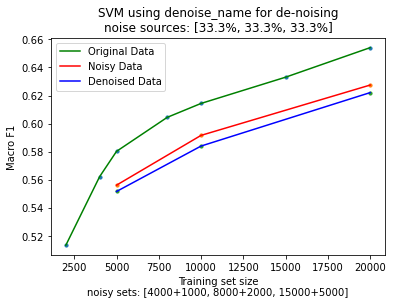

In [13]:
RUN = 1
if RUN:
    # Run new experiments
    # Set the function to classify data without denoising
    lab.set_experiment_no_denoising(experiment_without_denoising)

    # Set the function to classify data with denoising
    lab.set_experiment_with_denoising(experiment_with_denoising)

    print("-------------- No noisy training sets ----------")
    lab.do_batch_experiments(origin_train_set_sizes)

    print("-------------- Noisy training sets -------------")
    lab.do_batch_experiments(noisy_train_set_sizes)

    # Save the results
    lab.save("lab.pk")

    # Show evaluations in a form
    lab.print()

    # Plot the evaluations
    lab.plot()
else:
    # Read evaluations saved by previous experiments
    lab = Lab.load("lab.pk")

    # Show evaluations in a form
    lab.print()
    
    # Plot the evaluations
    lab.plot()
